<a href="https://colab.research.google.com/github/berdaniera/experiments/blob/master/Airports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Routing problem example

**Scenario:** 10 drop-offs from a common location with 4 airplanes, e.g., following a major event. (Extensions include different pickup and drop-off locations, capacity and time window constraints.)

In [ ]:
!pip install ortools
!pip install geopandas

## Load packages and data

Select random airport locations in the US as our points. Node 0 will be the starting point and all others will be drop-off points.

In [ ]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from sklearn.neighbors import DistanceMetric
from math import radians
import pandas as pd
import numpy as np

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [ ]:
airports = pd.read_csv("https://ourairports.com/countries/US/airports.csv")

In [ ]:
random_air = airports[airports.type == 'small_airport'].sample(10)
random_air['nid'] = range(10)
random_air

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,country_name,iso_country,region_name,iso_region,local_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,score,last_updated,nid
7397,11524,4M5,small_airport,Dermott Municipal Airport,33.487999,-91.442596,135.0,NaN,United States,US,Arkansas,US-AR,AR,Dermott,0,4M5,NaN,4M5,NaN,NaN,NaN,50,2008-06-13T14:30:04+00:00,0
7666,25823,WN28,small_airport,Sunny Slope Runway Airport,44.982800,-87.309502,730.0,NaN,United States,US,Wisconsin,US-WI,WI,Egg Harbor,0,WN28,NaN,WN28,NaN,NaN,NaN,50,2008-06-13T14:30:04+00:00,1
12675,21631,LL98,small_airport,John W Meils Restricted Landing Area,40.943600,-89.108299,705.0,NaN,United States,US,Illinois,US-IL,IL,Rutland,0,LL98,NaN,LL98,NaN,NaN,NaN,50,2009-12-27T05:51:01+00:00,2
418,19676,KDXR,small_airport,Danbury Municipal Airport,41.371498,-73.482201,458.0,NaN,United States,US,Connecticut,US-CT,CT,Danbury,0,KDXR,DXR,DXR,NaN,https://en.wikipedia.org/wiki/Danbury_Municipa...,NaN,50,2012-07-05T01:36:14+00:00,3
8769,7397,0ND6,small_airport,Schumacher Strip,46.055000,-99.917099,2020.0,NaN,United States,US,North Dakota,US-ND,ND,Hague,0,0ND6,NaN,0ND6,NaN,NaN,NaN,50,2008-07-13T21:58:20+00:00,4
3732,16838,CN29,small_airport,J-B Airport,37.935200,-121.014999,103.0,NaN,United States,US,California,US-CA,CA,Farmington,0,CN29,NaN,CN29,NaN,NaN,NaN,50,2008-06-13T14:30:04+00:00,5
10268,8988,24C,small_airport,Lowell City Airport,42.953899,-85.343903,681.0,NaN,United States,US,Michigan,US-MI,MI,Lowell,0,24C,NaN,24C,NaN,NaN,NaN,50,2008-06-13T14:30:04+00:00,6
21380,345406,US-4457,small_airport,Triple Eagle Ranch Airport,32.253060,-97.960370,1000.0,NaN,United States,US,Texas,US-TX,TX,Bluff Dale,0,NaN,NaN,NaN,NaN,NaN,NaN,0,2021-06-11T18:01:33+00:00,7
8910,21974,ME47,small_airport,Payne Field,44.854500,-69.456398,350.0,NaN,United States,US,Maine,US-ME,ME,Hartland,0,ME47,NaN,ME47,NaN,NaN,NaN,50,2008-06-13T14:30:04+00:00,8
24923,330461,47VT,small_airport,Cub Field,44.125677,-73.369616,140.0,NaN,United States,US,Vermont,US-VT,VT,Panton,0,47VT,NaN,47VT,NaN,NaN,NaN,0,2019-02-12T23:43:35+00:00,9


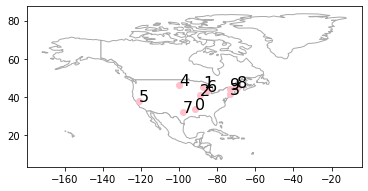

In [ ]:
# plot map
gdf = gpd.GeoDataFrame(random_air, 
                       geometry=gpd.points_from_xy(random_air.longitude_deg, random_air.latitude_deg))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'North America'].plot(color='white', edgecolor='darkgrey')
for x, y, label in zip(random_air.longitude_deg, random_air.latitude_deg, random_air.nid):
    ax.annotate(label, xy=(x, y), xytext=(0, 0), fontsize=16, textcoords="offset points")
gdf.plot(ax=ax, color='pink')

In [ ]:
# Generate data for analysis
# get Haversine distance between each point in km
random_air['latitude_rad'] = np.radians(random_air['latitude_deg'])
random_air['longitude_rad'] = np.radians(random_air['longitude_deg'])
dist = DistanceMetric.get_metric('haversine')
air_coords = random_air[['latitude_rad','longitude_rad']].to_numpy()
distance_km = dist.pairwise(air_coords)*6373 # km distance

data = {}
data['distance_matrix'] = np.ndarray.tolist(distance_km.astype(np.int))
data['num_vehicles'] = 4
data['depot'] = 0 # this is the starting/ending depot

# maximum travel distance
maxdist = int(max(5000, np.amax(distance_km)*2.1))

print(distance_km.astype(np.int))
# distance between each point

[[   0 1326  854 1807 1572 2704 1179  624 2267 1955]
 [1326    0  472 1189  988 2893  275 1688 1403 1107]
 [ 854  472    0 1307 1039 2745  383 1247 1654 1335]
 [1807 1189 1307    0 2177 4037  992 2393  506  306]
 [1572  988 1039 2177    0 1955 1204 1544 2365 2085]
 [2704 2893 2745 4037 1955    0 3047 2184 4296 3999]
 [1179  275  383  992 1204 3047    0 1625 1288  973]
 [ 624 1688 1247 2393 1544 2184 1625    0 2826 2508]
 [2267 1403 1654  506 2365 4296 1288 2826    0  320]
 [1955 1107 1335  306 2085 3999  973 2508  320    0]]


Functions and parameters based on https://developers.google.com/optimization/routing/vrp

In [ ]:
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))

Optimization parameters

In [ ]:
# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Optimization parameters -- we're solving for the cumulative distance
dimension_name = 'Distance'
routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        maxdist,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [ ]:
# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
if solution:
    print_solution(data, manager, routing, solution)
else:
    print('No solution found !')


Objective: 555464
Route for vehicle 0:
 0 ->  7 ->  4 ->  1 ->  6 ->  2 -> 0
Distance of the route: 4668m

Route for vehicle 1:
 0 -> 0
Distance of the route: 0m

Route for vehicle 2:
 0 ->  9 ->  8 ->  3 -> 0
Distance of the route: 4588m

Route for vehicle 3:
 0 ->  5 -> 0
Distance of the route: 5408m

Maximum of the route distances: 5408m
